In [1]:
# importing the necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
#import plotly.express as px
#import plotly.io as pio
#import plotly.graph_objects as go
import shap

from scipy import stats
from scipy.stats import norm, skew 

from sklearn.metrics import precision_score, recall_score, accuracy_score, r2_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import Lasso

from yellowbrick.model_selection import FeatureImportances

#plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

# Model Accuracies
ml_accuracies = dict()

#%pip install yellowbrick

#!pip install seaborn 

#!pip install shap


In [2]:
# Colors
colors = ['lightcoral',
          'brown',
          'lightseagreen',
          'maroon',
          'deeppink',
          'darkorange',
          'royalblue',
          'darkviolet',
          'gold',
          'crimson',
          'lightsteelblue',
          'salmon',
          'mediumseagreen',
          'olivedrab',
          'blue',
          'limegreen',
          'slateblue',
          'red',
          'steelblue',
          'teal',
          'peru',
          'dimgray',
          'violet',
          'cyan']

In [3]:
df = pd.read_csv("cancer patient data sets.csv", index_col='index')

# Index Column now refers to patient
df.drop("Patient Id", axis=1, inplace=True)

# cleaning column names
df.rename(columns=str.lower, inplace=True)
df.rename(columns={col: col.replace(" ", "_") for col in df.columns}, inplace=True)

display(df)


age  gender  air_pollution  alcohol_use  dust_allergy  \
index                                                          
0       33       1              2            4             5   
1       17       1              3            1             5   
2       35       1              4            5             6   
3       37       1              7            7             7   
4       46       1              6            8             7   
...    ...     ...            ...          ...           ...   
995     44       1              6            7             7   
996     37       2              6            8             7   
997     25       2              4            5             6   
998     18       2              6            8             7   
999     47       1              6            5             6   

       occupational_hazards  genetic_risk  chronic_lung_disease  \
index                                                             
0                         4             3                     2   
1                         3             4                     2   
2                         5             5                     4   
3                         7             6                     7   
4                         7             7                     6   
...                     ...           ...                   ...   
995                       7             7                     6   
996                       7             7                     6   
997                       5             5                     4   
998                       7             7                     6   
999                       5             5                     4   

       balanced_diet  obesity  ...  fatigue  weight_loss  shortness_of_breath  \
index                          ...                                              
0                  2        4  ...        3            4                    2   
1                  2        2  ...        1            3                    7   
2                  6        7  ...        8            7                    9   
3                  7        7  ...        4            2                    3   
4                  7        7  ...        3            2                    4   
...              ...      ...  ...      ...          ...                  ...   
995                7        7  ...        5            3                    2   
996                7        7  ...        9            6                    5   
997                6        7  ...        8            7                    9   
998                7        7  ...        3            2                    4   
999                6        7  ...        8            7                    9   

       wheezing  swallowing_difficulty  clubbing_of_finger_nails  \
index                                                              
0             2                      3                         1   
1             8                      6                         2   
2             2                      1                         4   
3             1                      4                         5   
4             1                      4                         2   
...         ...                    ...                       ...   
995           7                      8                         2   
996           7                      2                         4   
997           2                      1                         4   
998           1                      4                         2   
999           2                      1                         4   

       frequent_cold  dry_cough  snoring   level  
index                                             
0                  2          3        4     Low  
1                  1          7        2  Medium  
2                  6          7        2    High  
3                  6          7        5    High  
4                  4          2        3    High  
...   

In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   age                       1000 non-null   int64 
 1   gender                    1000 non-null   int64 
 2   air_pollution             1000 non-null   int64 
 3   alcohol_use               1000 non-null   int64 
 4   dust_allergy              1000 non-null   int64 
 5   occupational_hazards      1000 non-null   int64 
 6   genetic_risk              1000 non-null   int64 
 7   chronic_lung_disease      1000 non-null   int64 
 8   balanced_diet             1000 non-null   int64 
 9   obesity                   1000 non-null   int64 
 10  smoking                   1000 non-null   int64 
 11  passive_smoker            1000 non-null   int64 
 12  chest_pain                1000 non-null   int64 
 13  coughing_of_blood         1000 non-null   int64 
 14  fatigue                   1000

In [5]:
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap='rainbow')


In [6]:
print('Cancer Levels: ', df['level'].unique())

# Replacing levels of numeric int
mapping = {'High': 2, 'Medium': 1, 'Low': 0}
df["level"].replace(mapping, inplace=True)
print('Cancer Levels: ', df['level'].unique())

Cancer Levels:  ['Low' 'Medium' 'High']
Cancer Levels:  [0 1 2]


In [7]:
round(df.describe().iloc[1:, ].T, 3).style.format(precision=3).background_gradient(axis=1)

In [8]:
# Showing data
X = df.drop(columns='level')
y = df.level

display(X.head(10))
print(y[:10])

age  gender  air_pollution  alcohol_use  dust_allergy  \
index                                                          
0       33       1              2            4             5   
1       17       1              3            1             5   
2       35       1              4            5             6   
3       37       1              7            7             7   
4       46       1              6            8             7   
5       35       1              4            5             6   
6       52       2              2            4             5   
7       28       2              3            1             4   
8       35       2              4            5             6   
9       46       1              2            3             4   

       occupational_hazards  genetic_risk  chronic_lung_disease  \
index                                                             
0                         4             3                     2   
1                         3             4                     2   
2                         5             5                     4   
3                         7             6                     7   
4                         7             7                     6   
5                         5             5                     4   
6                         4             3                     2   
7                         3             2                     3   
8                         5             6                     5   
9                         2             4                     3   

       balanced_diet  obesity  ...  coughing_of_blood  fatigue  weight_loss  \
index                          ...                                            
0                  2        4  ...                  4        3            4   
1                  2        2  ...                  3        1            3   
2                  6        7  ...                  8        8            7   
3                  7        7  ...                  8        4            2   
4                  7        7  ...                  9        3            2   
5                  6        7  ...                  8        8            7   
6                  2        4  ...                  4        3            4   
7                  4        3  ...                  1        3            2   
8                  5        5  ...                  5        1            4   
9                  3        3  ...                  4        1            2   

       shortness_of_breath  wheezing  swallowing_difficulty  \
index                                                         
0                        2         2                      3   
1                        7         8                      6   
2                        9         2                      1   
3                        3         1                      4   
4                        4         1                      4   
5                        9         2                      1   
6                        2         2                      3   
7                        2         4                      2   
8                        3         2                      4   
9                        4         6                      5   

       clubbing_of_finger_nails  frequent_cold  dry_cough  snoring  
index                                                               
0                             1              2          3        4  
1                             2              1          7        2  
2                             4              6          7        2  
3                             5              6          7        5  
4                             2              4          2        3  
5                             4              6          7        2  
6                             1              2          3        4  
7                             2              3          4        3  
8                             6      

index
0    0
1    1
2    2
3    2
4    2
5    2
6    0
7    0
8    1
9    1
Name: level, dtype: int64


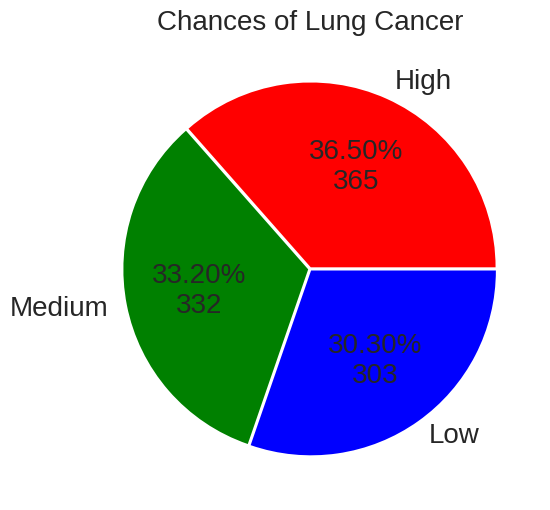

In [9]:
plt.figure(figsize=(6, 6))
plt.title('Chances of Lung Cancer', fontsize=20)
plt.pie(df.level.value_counts(),
    labels=mapping.keys(),
    #colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    colors=['red', 'green', 'blue'],#,'#FA0000'], 

    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(df.level.value_counts() /100)),
    explode=tuple(0.01 for i in range(3)),
    textprops={'fontsize': 20}
)
plt.show()

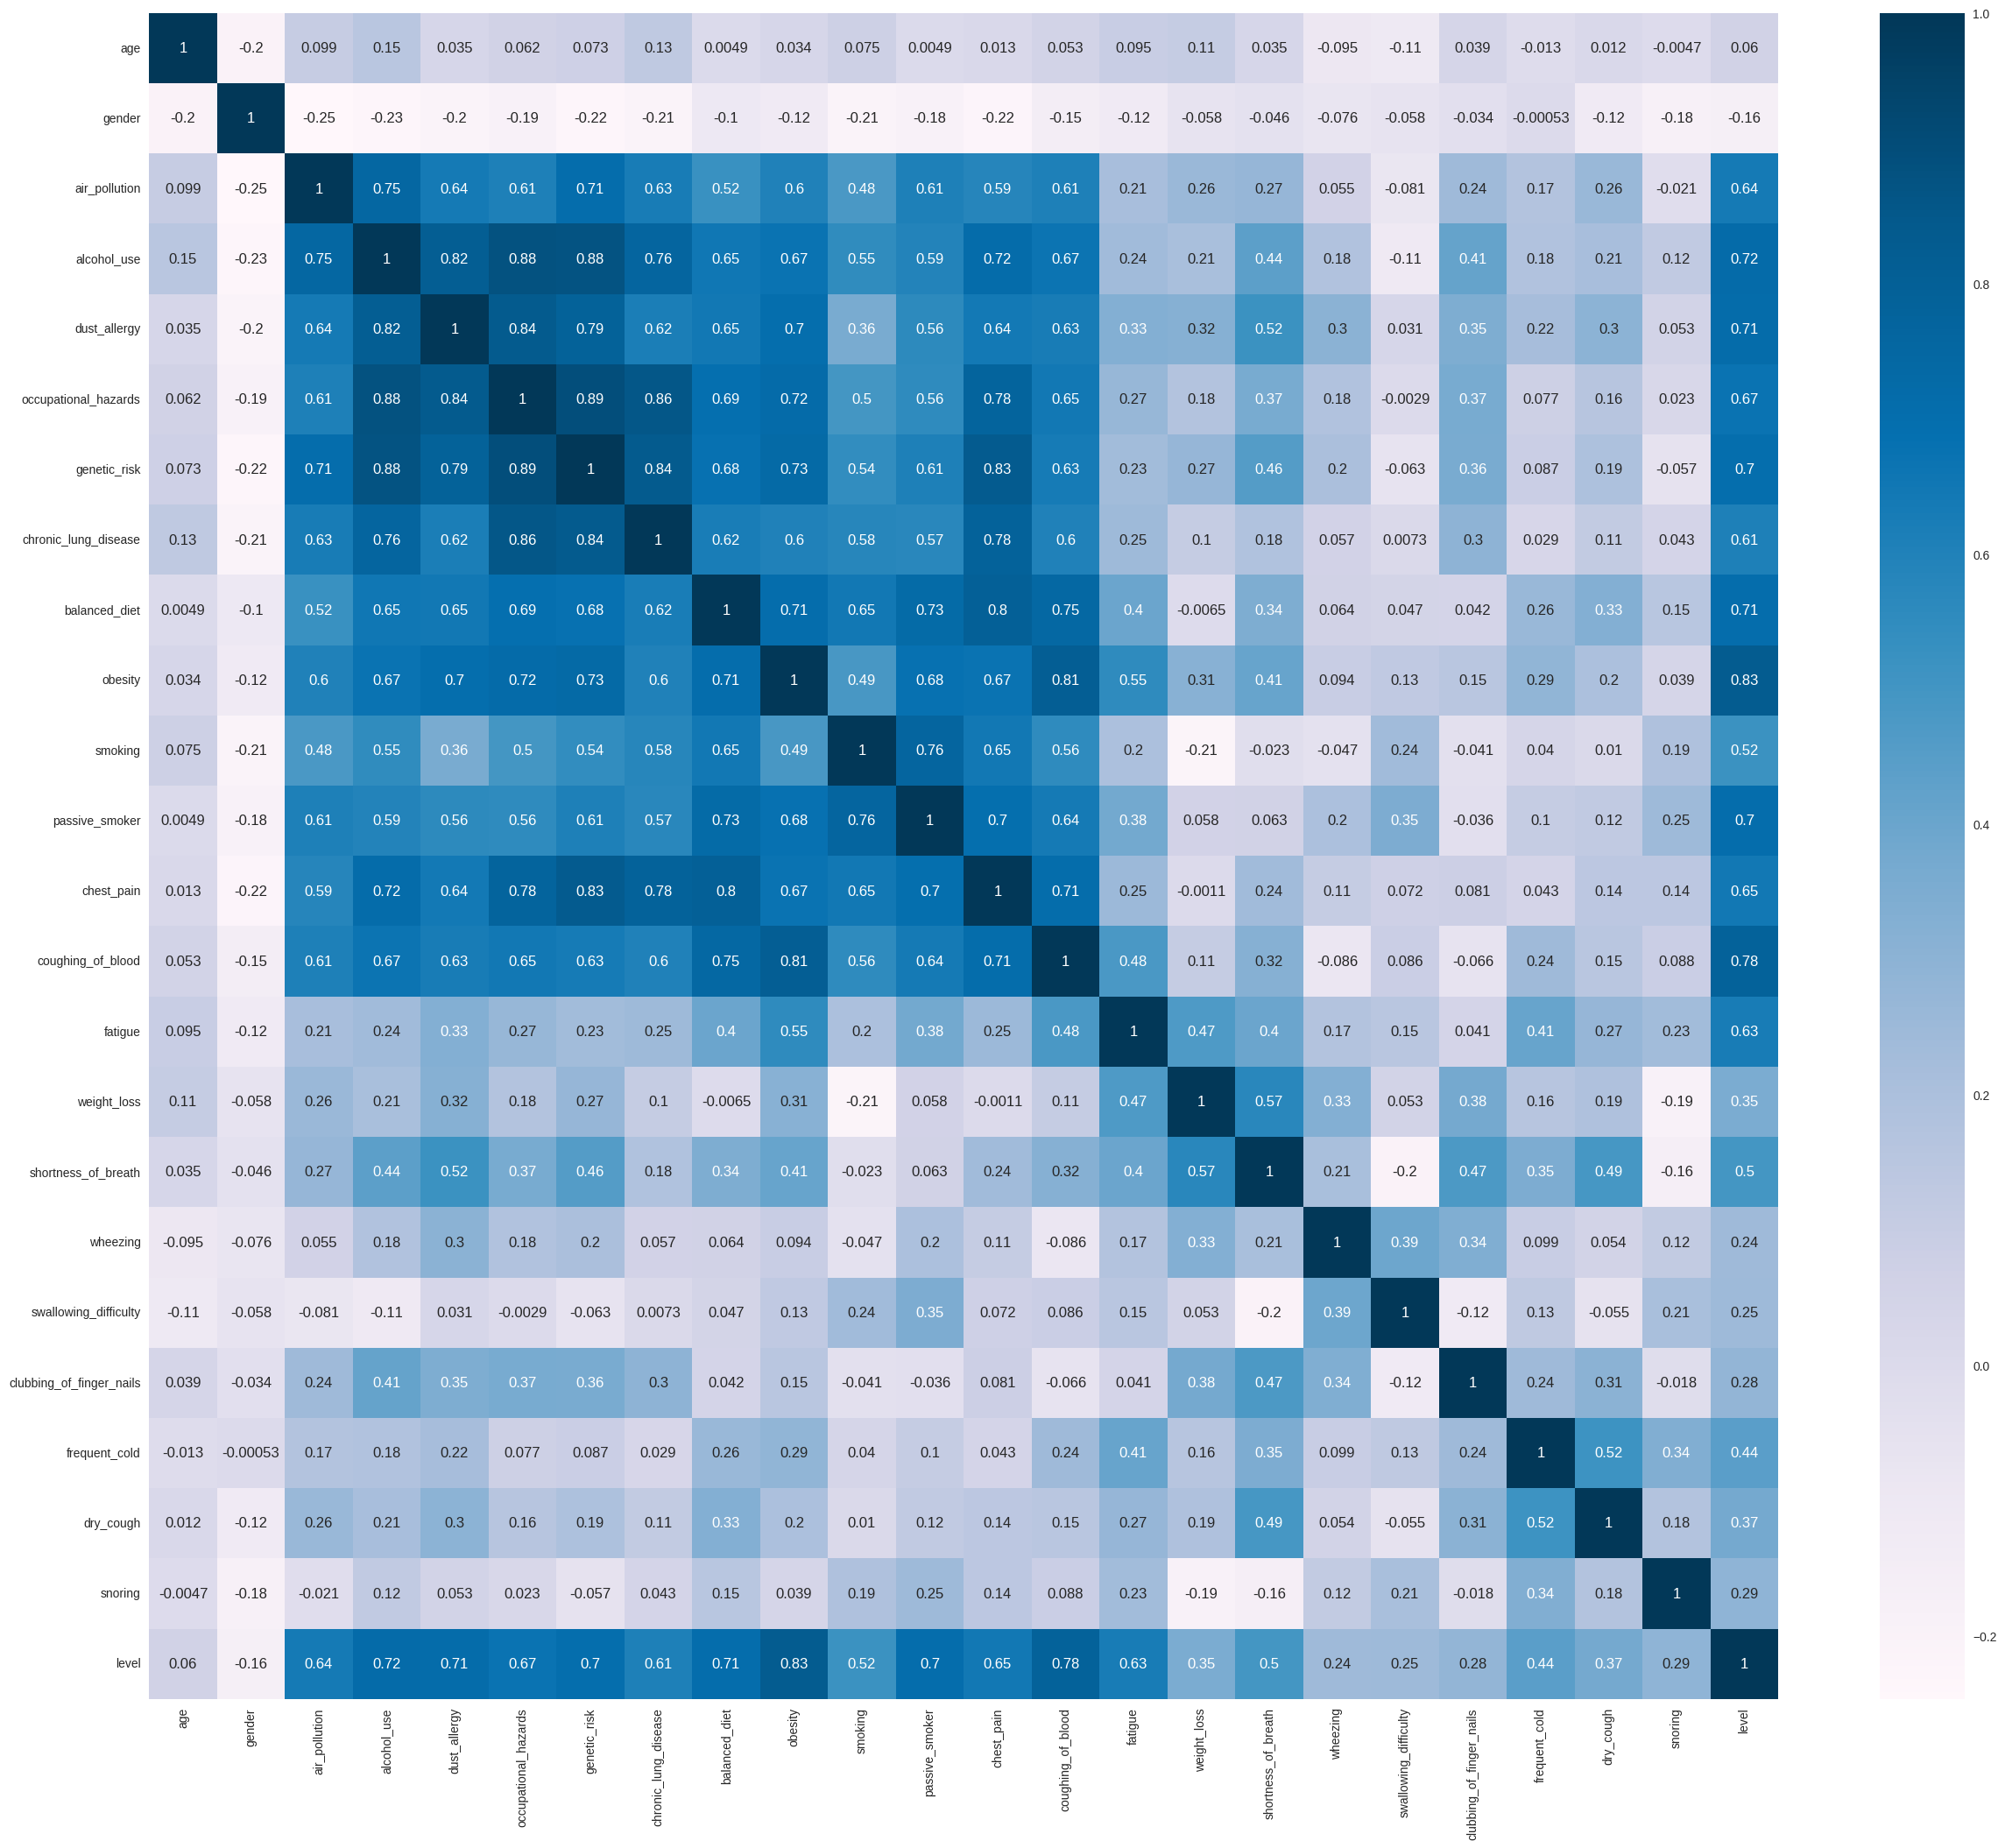

In [10]:
# Correlation plot
plt.figure(figsize=(30,25))
sns.heatmap(df.corr(),annot=True,cmap=plt.cm.PuBu)
plt.show()

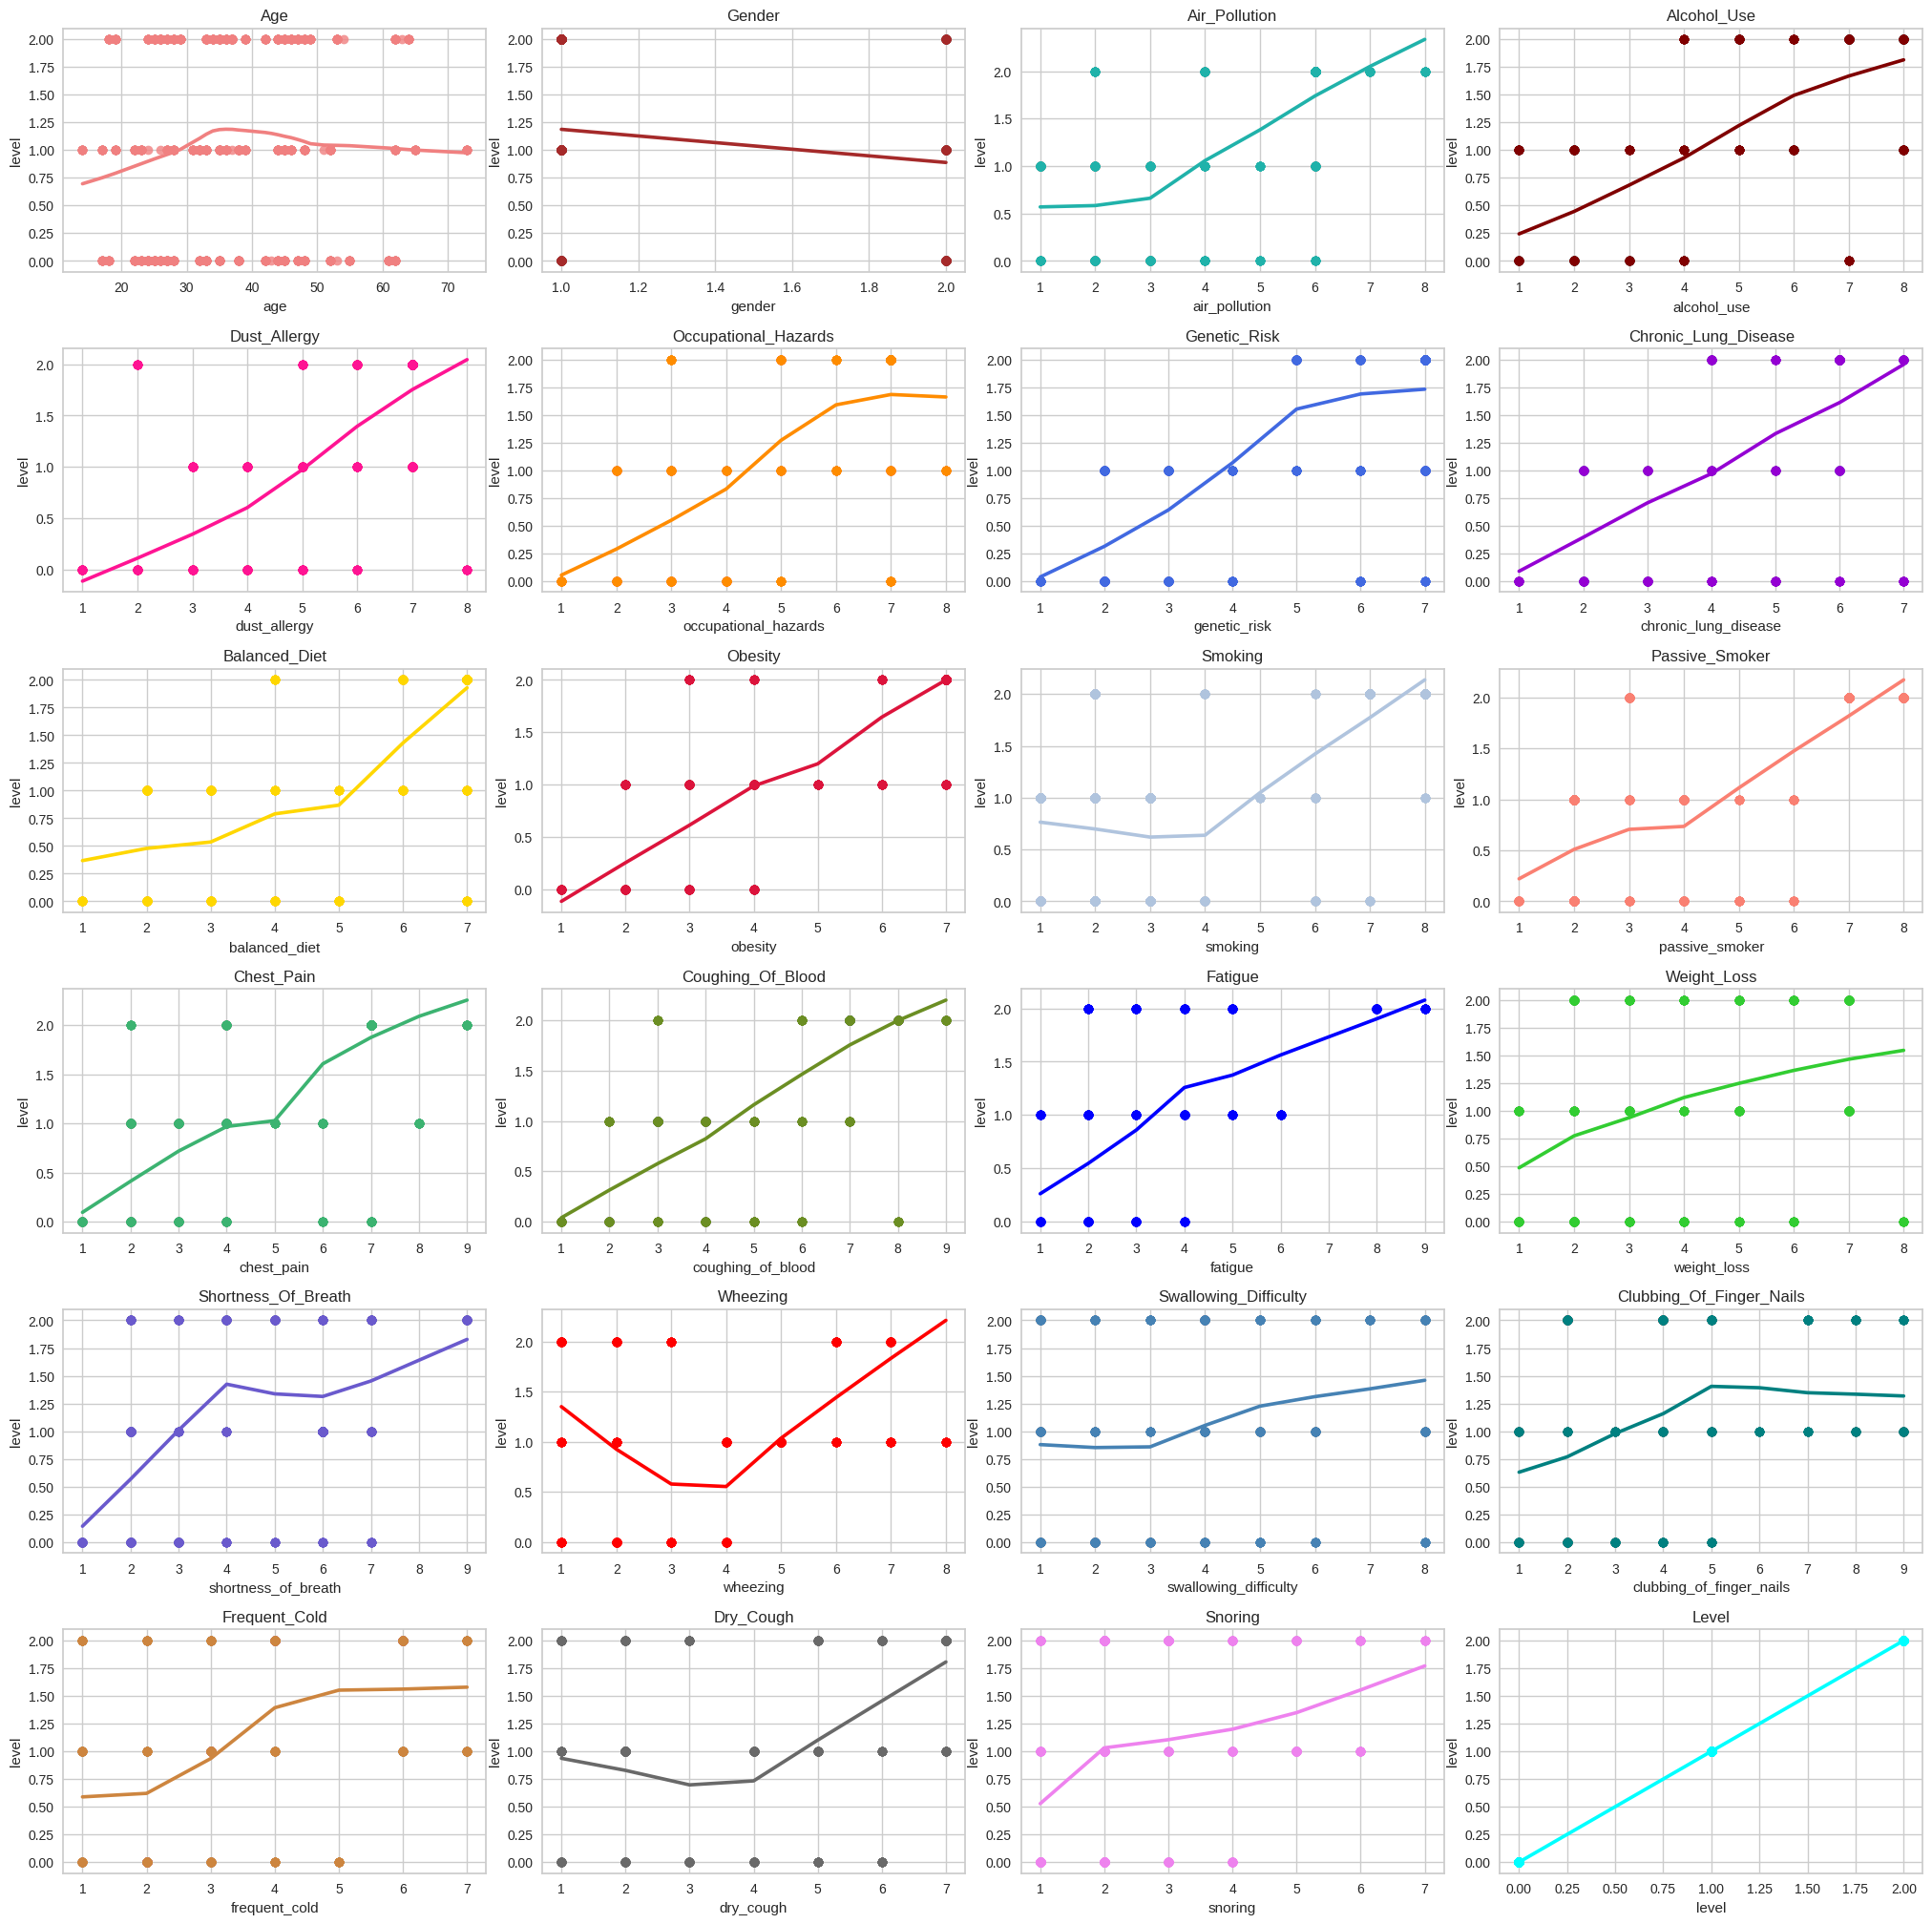

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(20, 20))
ax = ax.flatten()

for i, col in enumerate(df.columns):
    sns.regplot(x=col, y='level', data=df, lowess=True, color=colors[i], ax=ax[i])
    ax[i].set_title(col.title())
    
plt.tight_layout(pad=0.1, w_pad=0.6, h_pad=1)
plt.show()

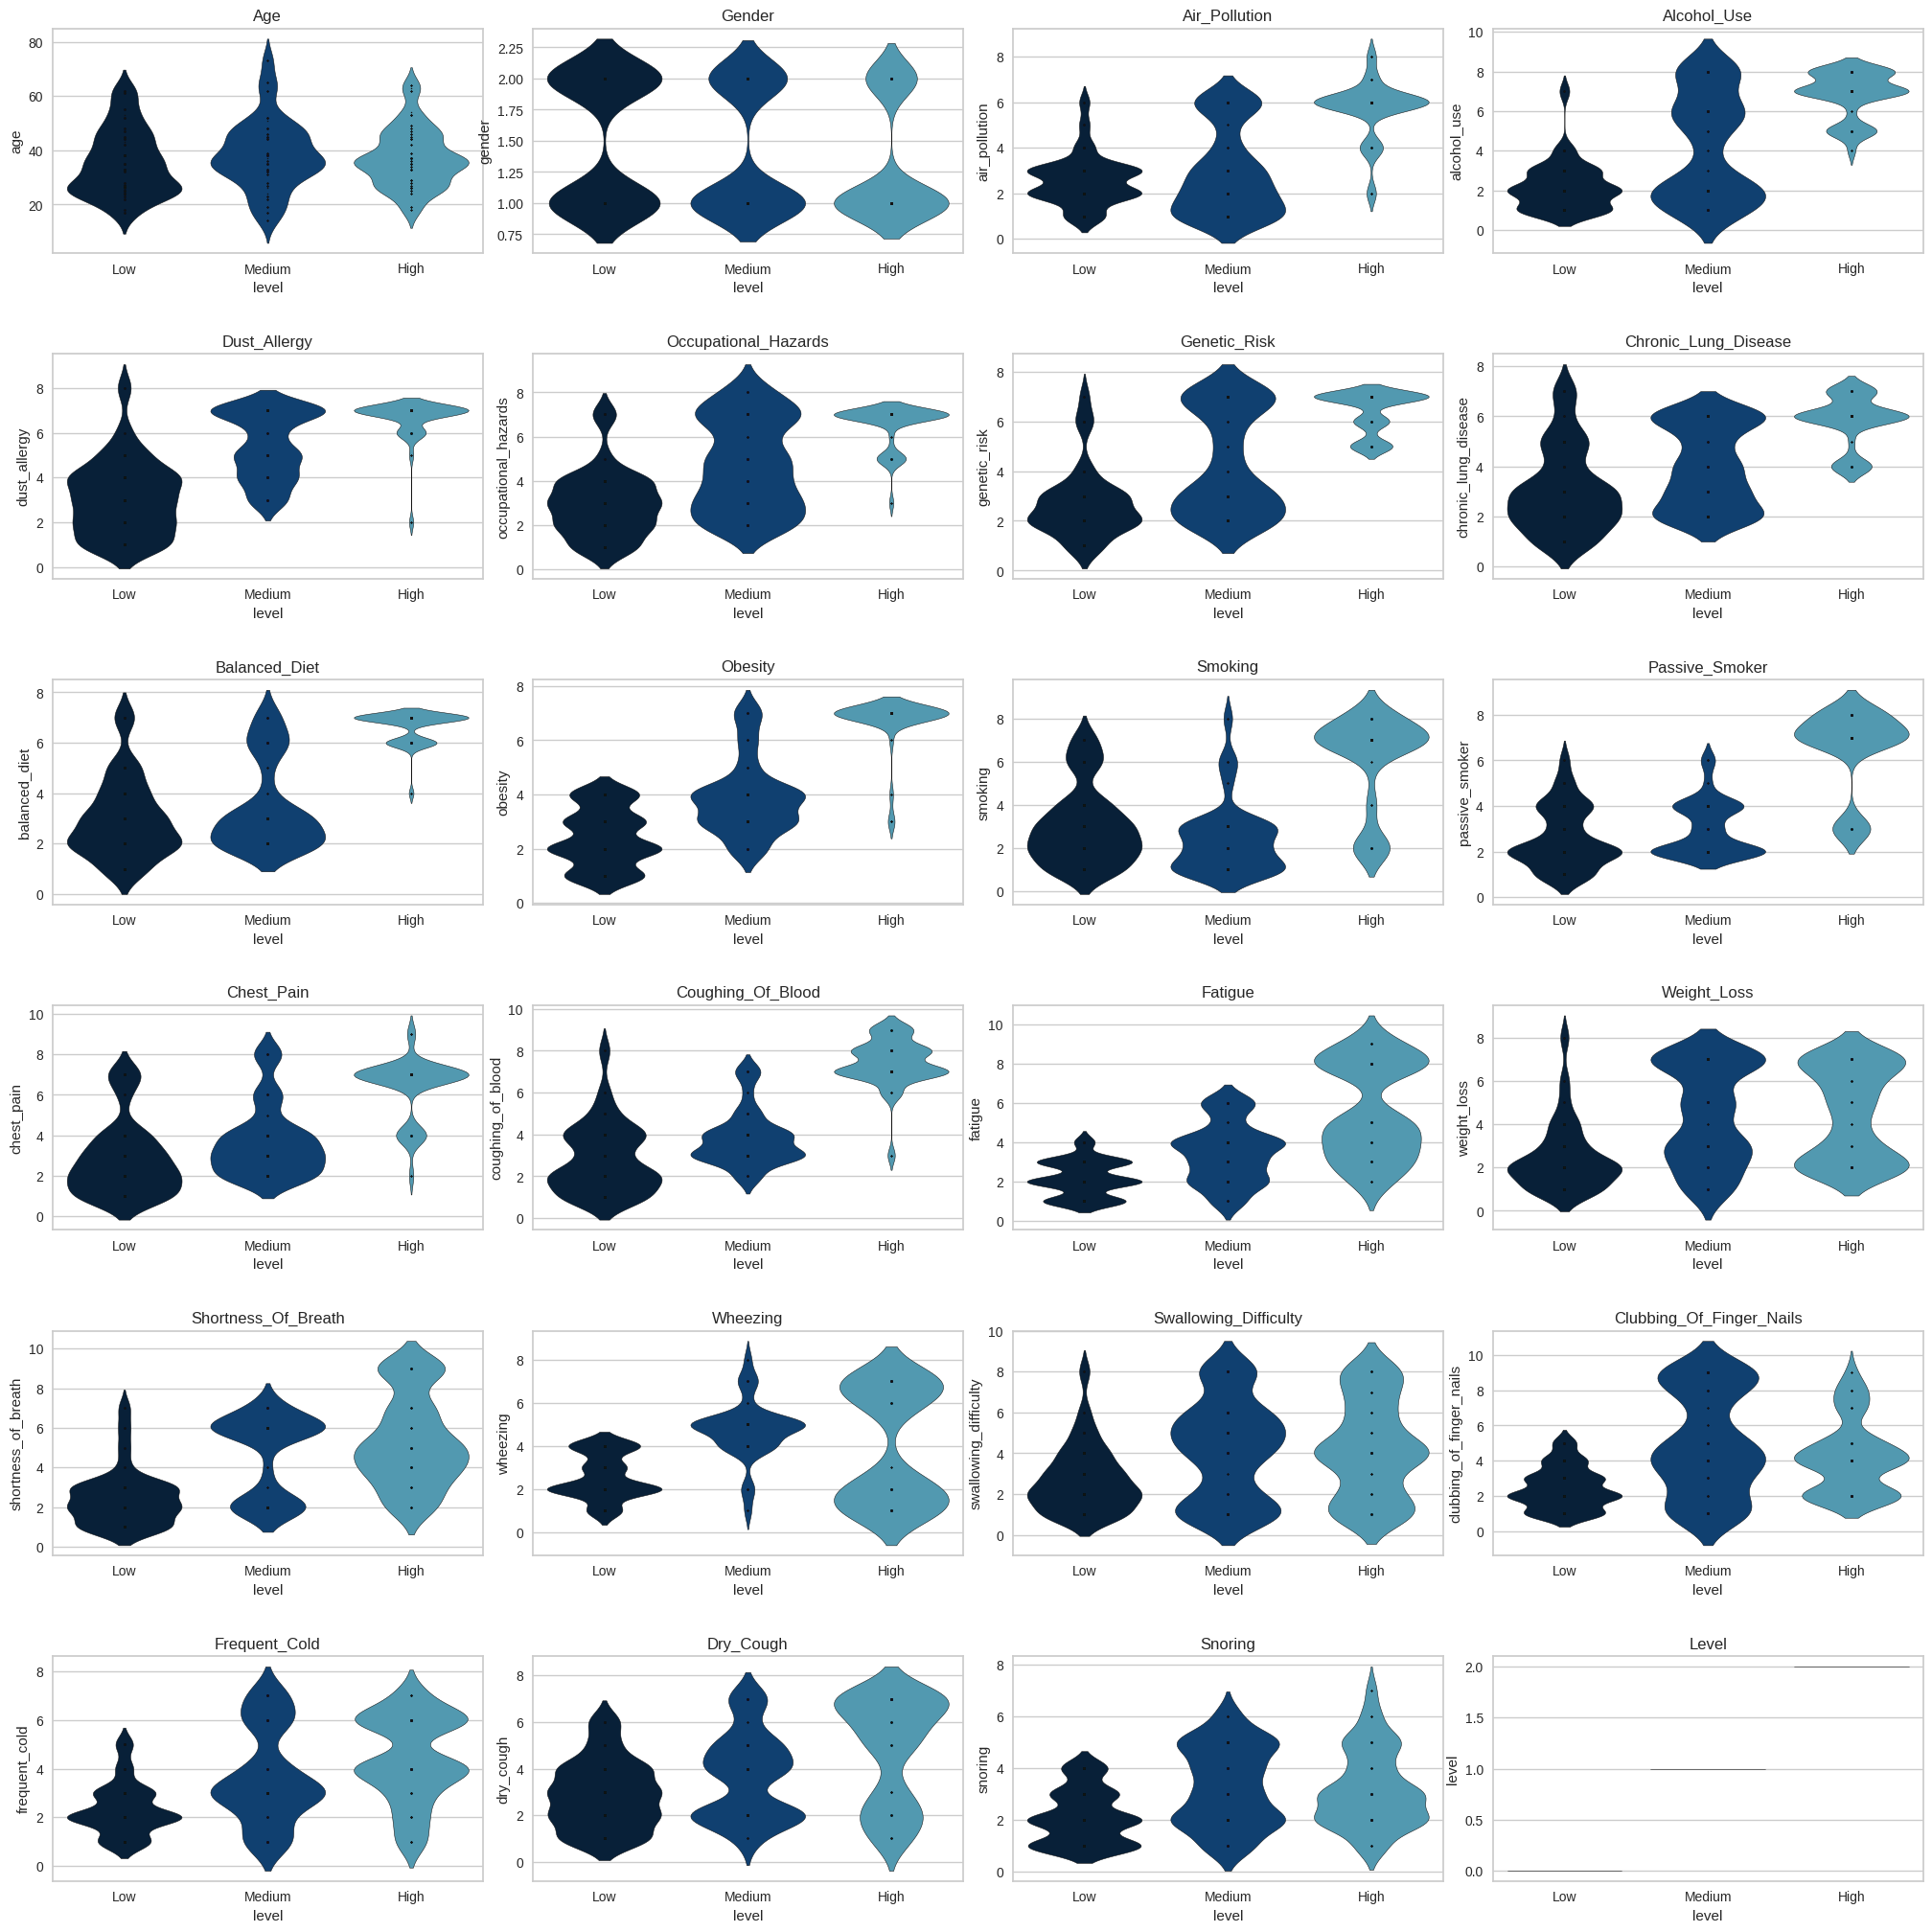

In [12]:
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(20, 20))
ax = ax.flatten()

for i, col in enumerate(df.columns):
    sns.violinplot(x=df['level'].replace(dict(zip(mapping.values(), mapping.keys()))),
                   y=col, data=df, inner="points",hue_order='level', palette='ocean', ax=ax[i])
    ax[i].set_title(col.title())
    
plt.tight_layout(pad=0.1, w_pad=0.2, h_pad=2.5)
plt.show()

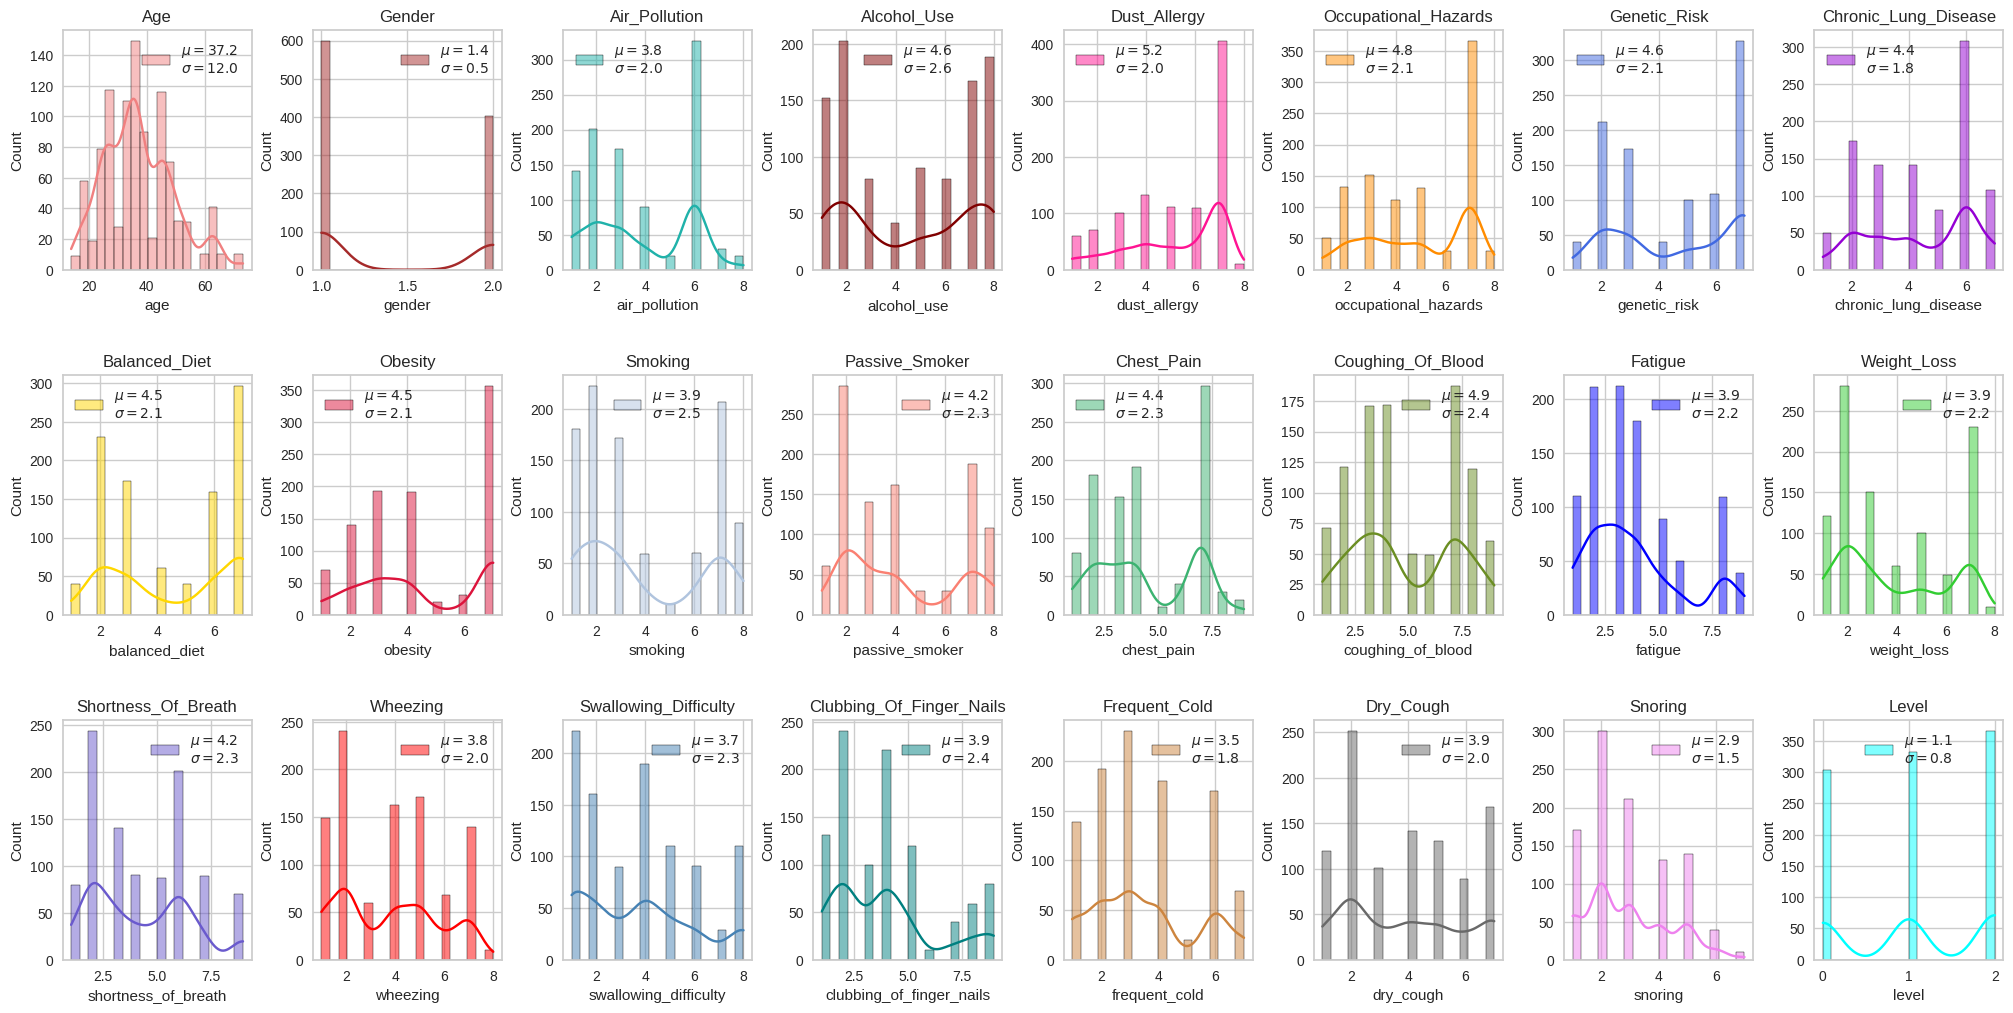

In [13]:
fig, ax = plt.subplots(ncols=8, nrows=3, figsize=(20, 10))
ax = ax.flatten()
i = 0

for k, v in df.items():
    mu, sigma = norm.fit(v)
    sns.histplot(v,
                 kde=True,
                 bins=20,
                 color=colors[i],
                 ax=ax[i],
                 label=f'$\mu={mu:.1f}$\n$\sigma={sigma:.1f}$')
    ax[i].set_title(f'{k.title()}')
    ax[i].legend()
    i += 1
    
plt.tight_layout(pad=0.2, w_pad=0.2, h_pad=2.5)
plt.show()

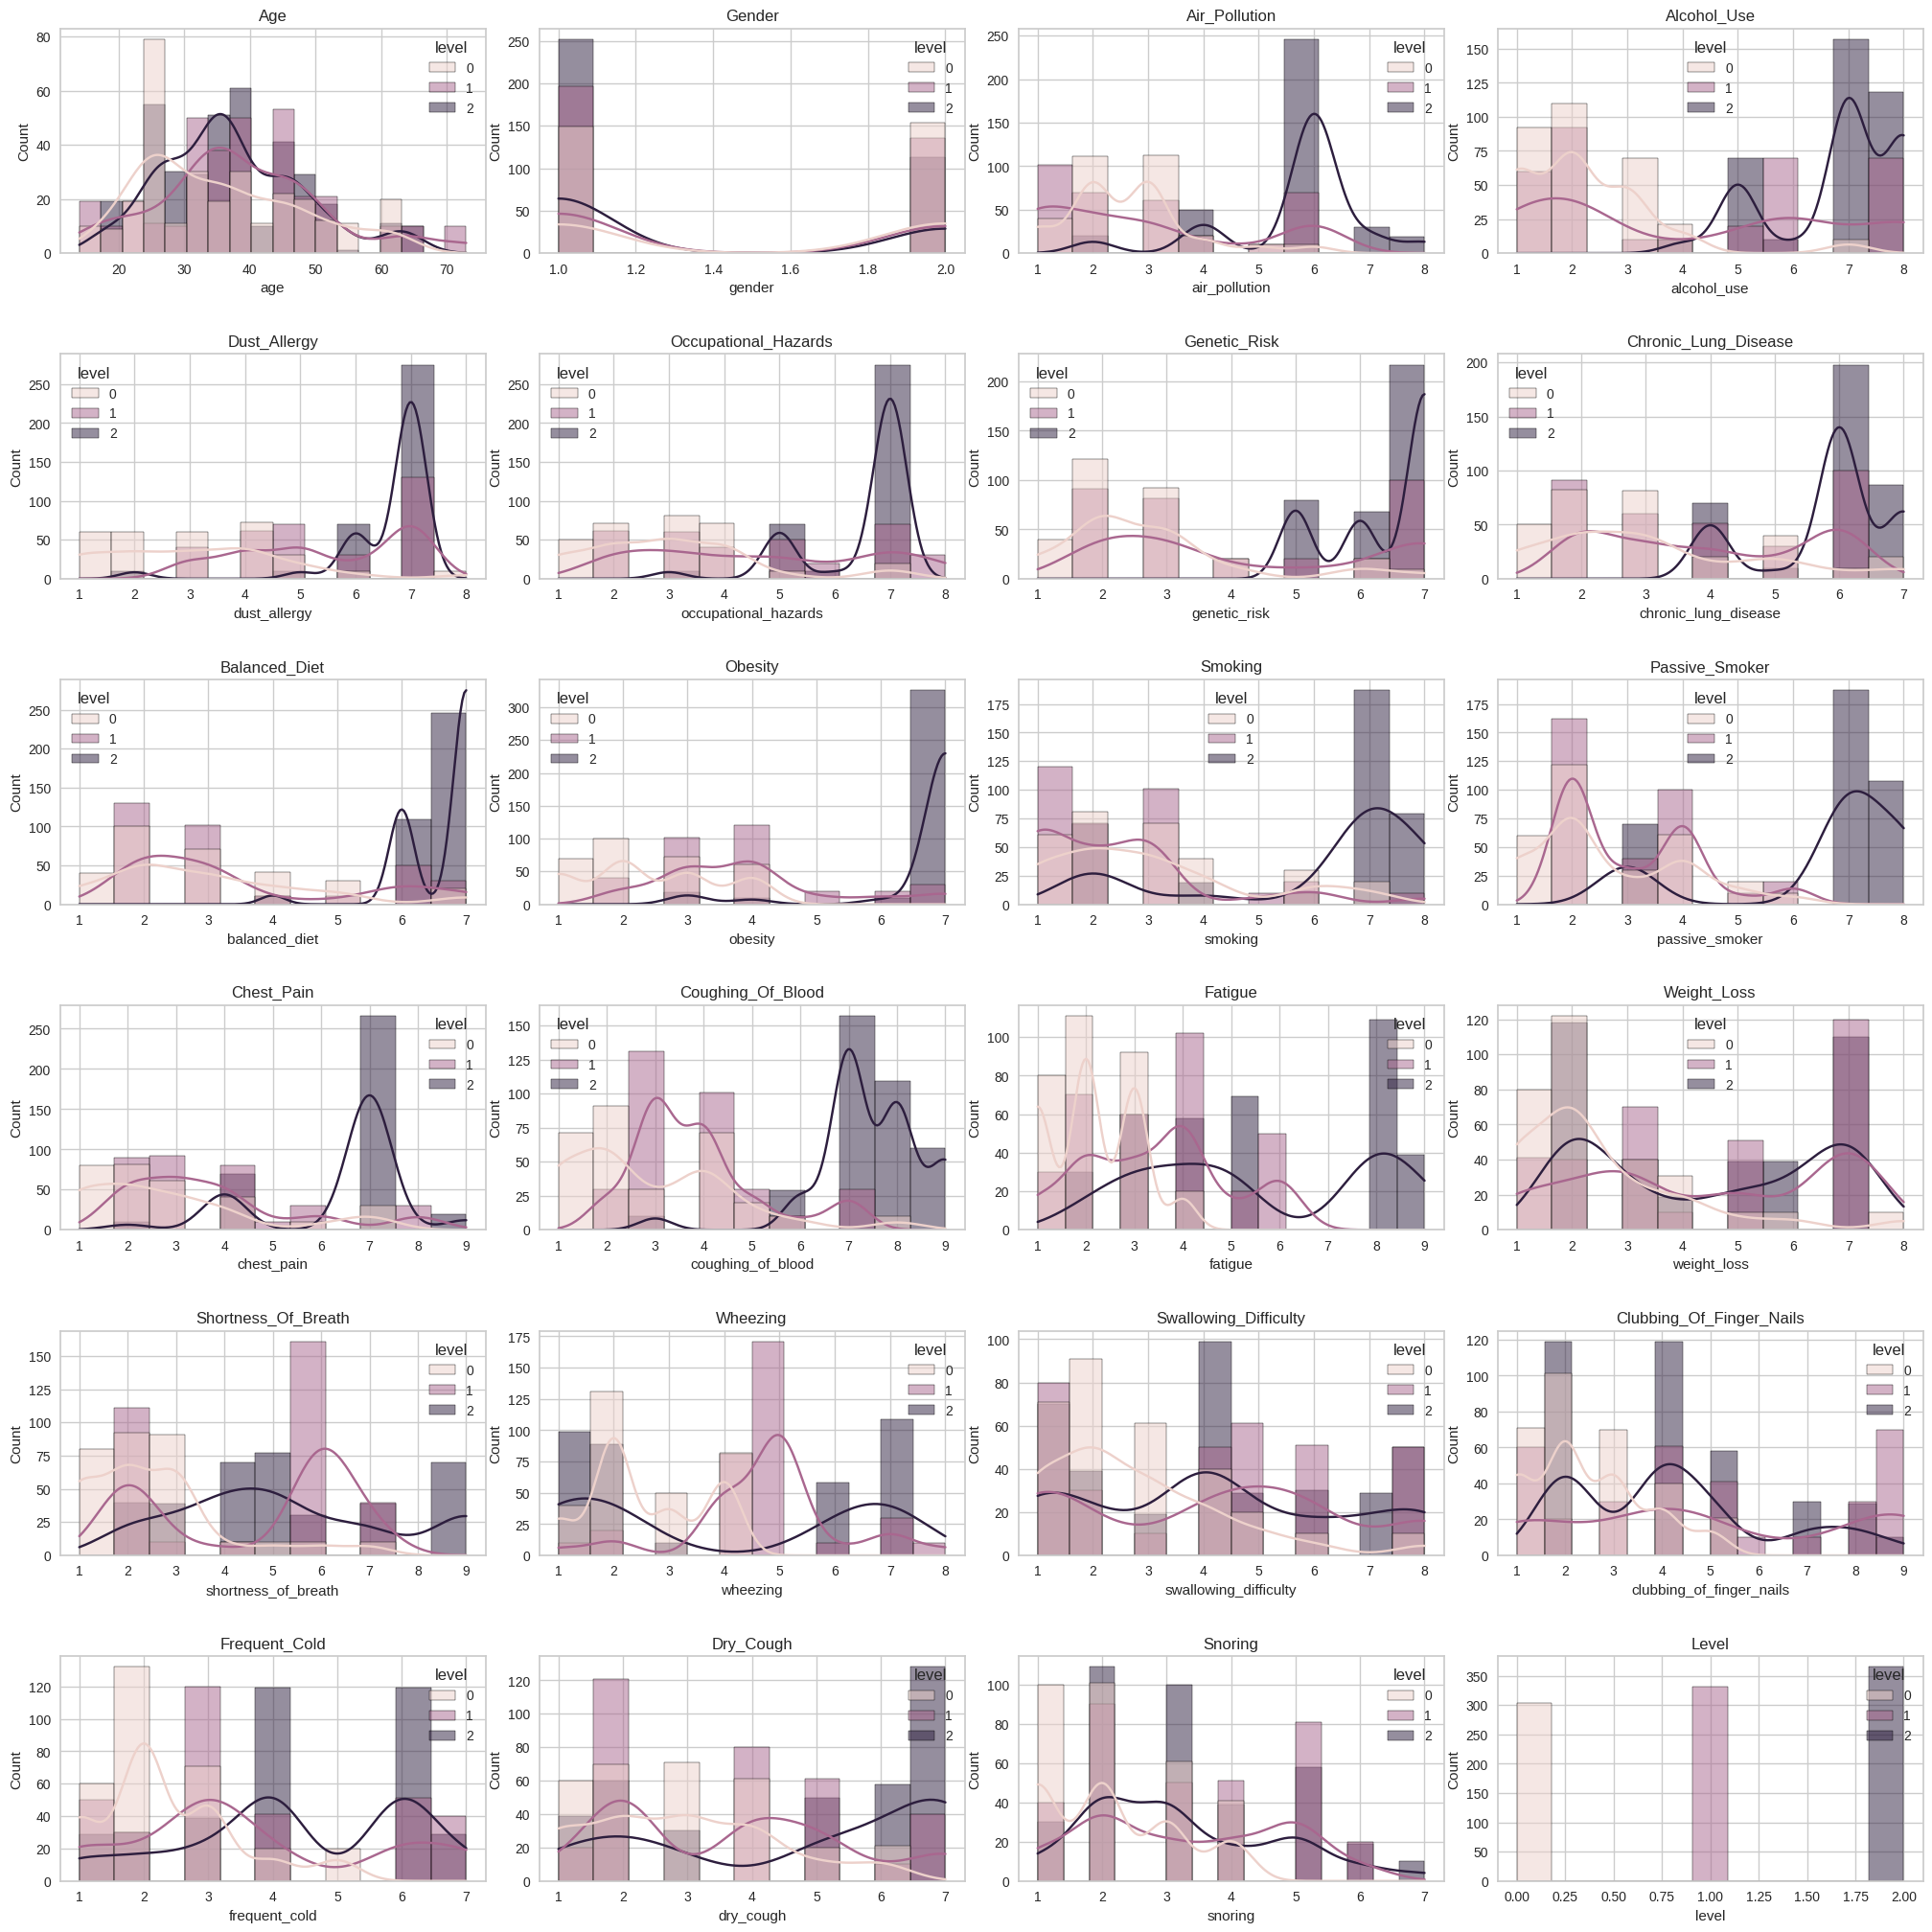

In [14]:
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(20, 20))
ax = ax.flatten()

for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, kde=True, hue="level", ax=ax[i])
    ax[i].set_title(col.title())
    
plt.tight_layout(pad=0.1, w_pad=0.2, h_pad=2.5)
plt.show()

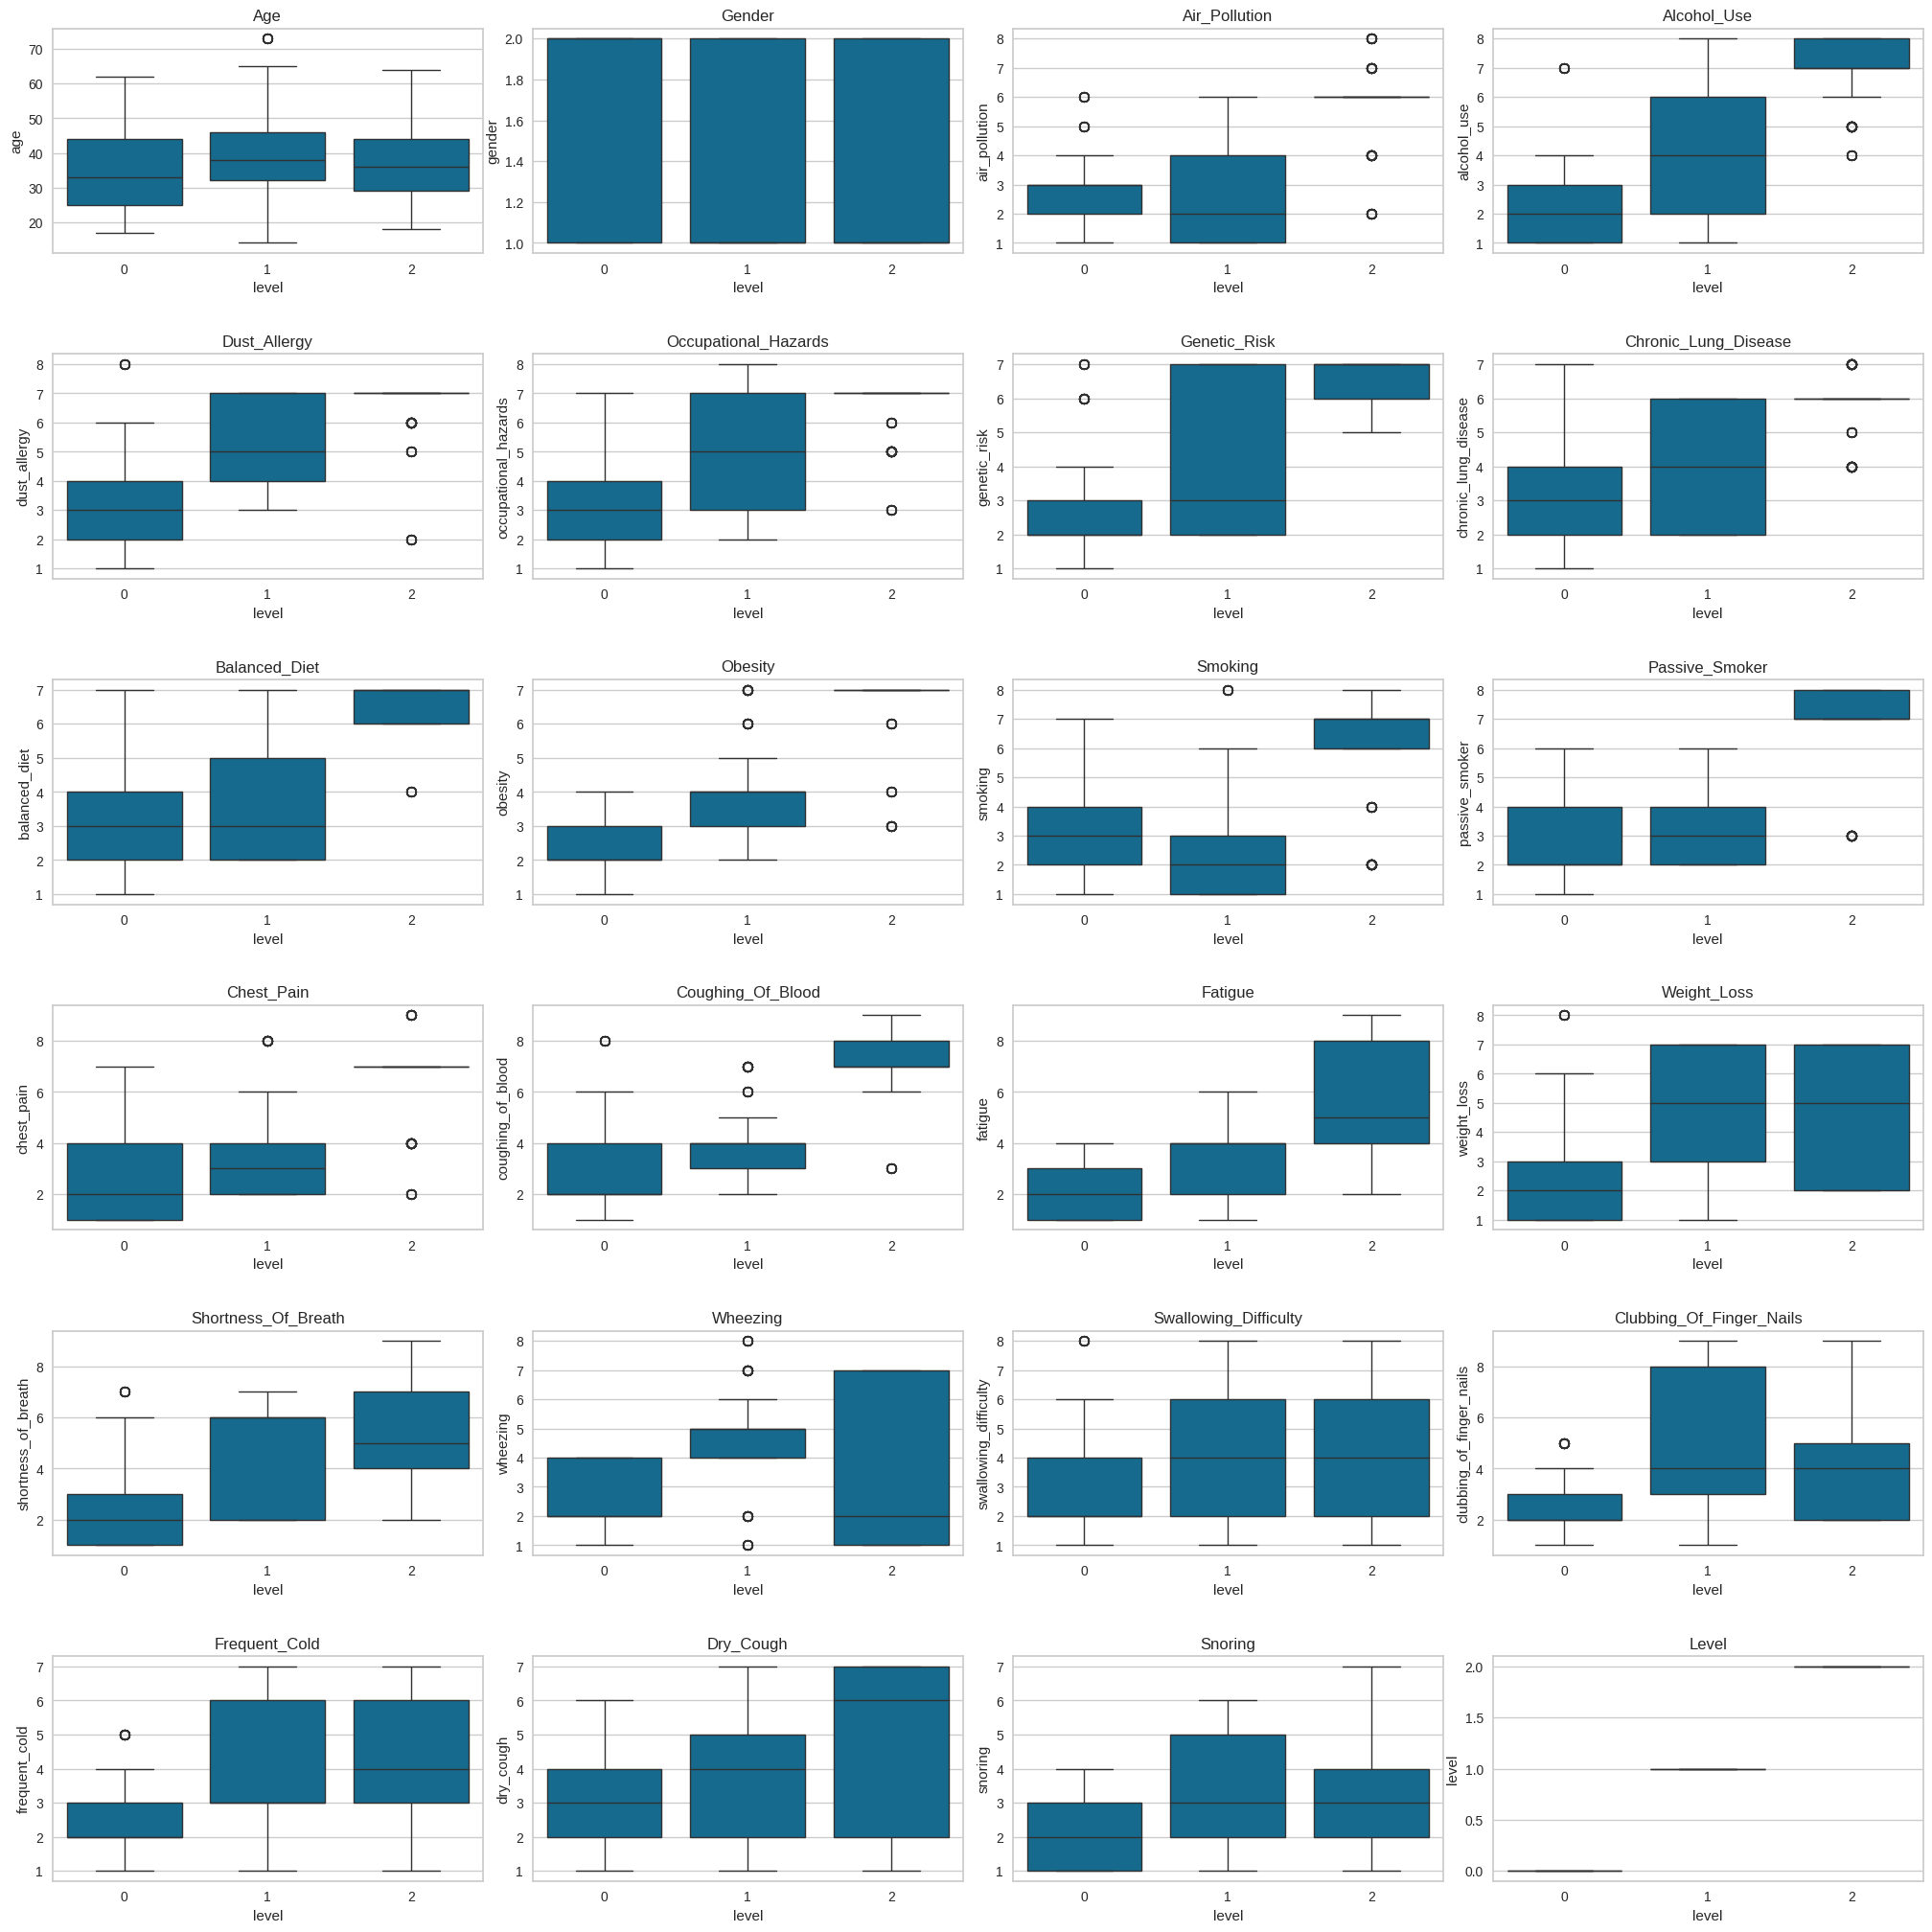

In [15]:
fig, ax = plt.subplots(ncols=4, nrows=6, figsize=(20, 20))
ax = ax.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(data=df, x='level', y=col, ax=ax[i])
    ax[i].set_title(col.title())
    
plt.tight_layout(pad=0.1, w_pad=0.2, h_pad=2.5)
plt.show()

In [16]:
# Splitting the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=40)
print(f'Shapes - X Training: {X_train.shape} and X Testing {X_test.shape}')
print(f'Shapes - Y Training: {y_train.shape} and Y Testing {y_test.shape}')

print(f'\nTraining output counts\n{y_train.value_counts()}')

Shapes - X Training: (700, 23) and X Testing (300, 23)
Shapes - Y Training: (700,) and Y Testing (300,)

Training output counts
level
2    248
1    233
0    219
Name: count, dtype: int64


### Random Forest Classifier


In [17]:
def random_forest_n_best(X_train, y_train, X_test, y_test, n_list):
    
    scores = []
    
    for n in n_list:
        RF = RandomForestClassifier(n_estimators=n, random_state=40)
        RF.fit(X_train, y_train)
        RF_pred = RF.predict(X_test)

        scores.append(accuracy_score(y_test, RF_pred))

    plt.plot(n_list, scores)
    plt.xlabel('n_estimators for Random Forest Classifier')
    plt.ylabel('Testing Accuracy')
    plt.grid(alpha=0.1)
    plt.show()

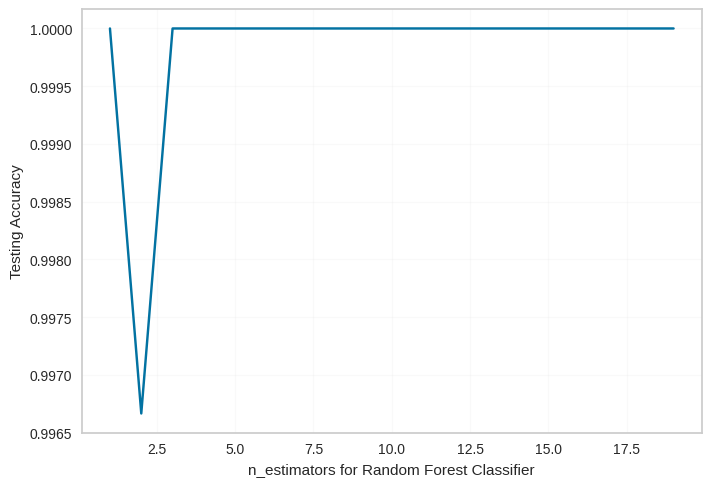

In [18]:
# n Accuracy analysis
random_forest_n_best(X_train, y_train, X_test, y_test, n_list=np.arange(1,20,1))

In [19]:
# Define model and set random_state
rfc_model = RandomForestClassifier(n_estimators=3, random_state=42)

# fitting model
rfc_model.fit(X_train, y_train)

# predicting with model
rfc_pred = rfc_model.predict(X_test)
pd.Series(rfc_pred).value_counts()

2    117
1     99
0     84
Name: count, dtype: int64

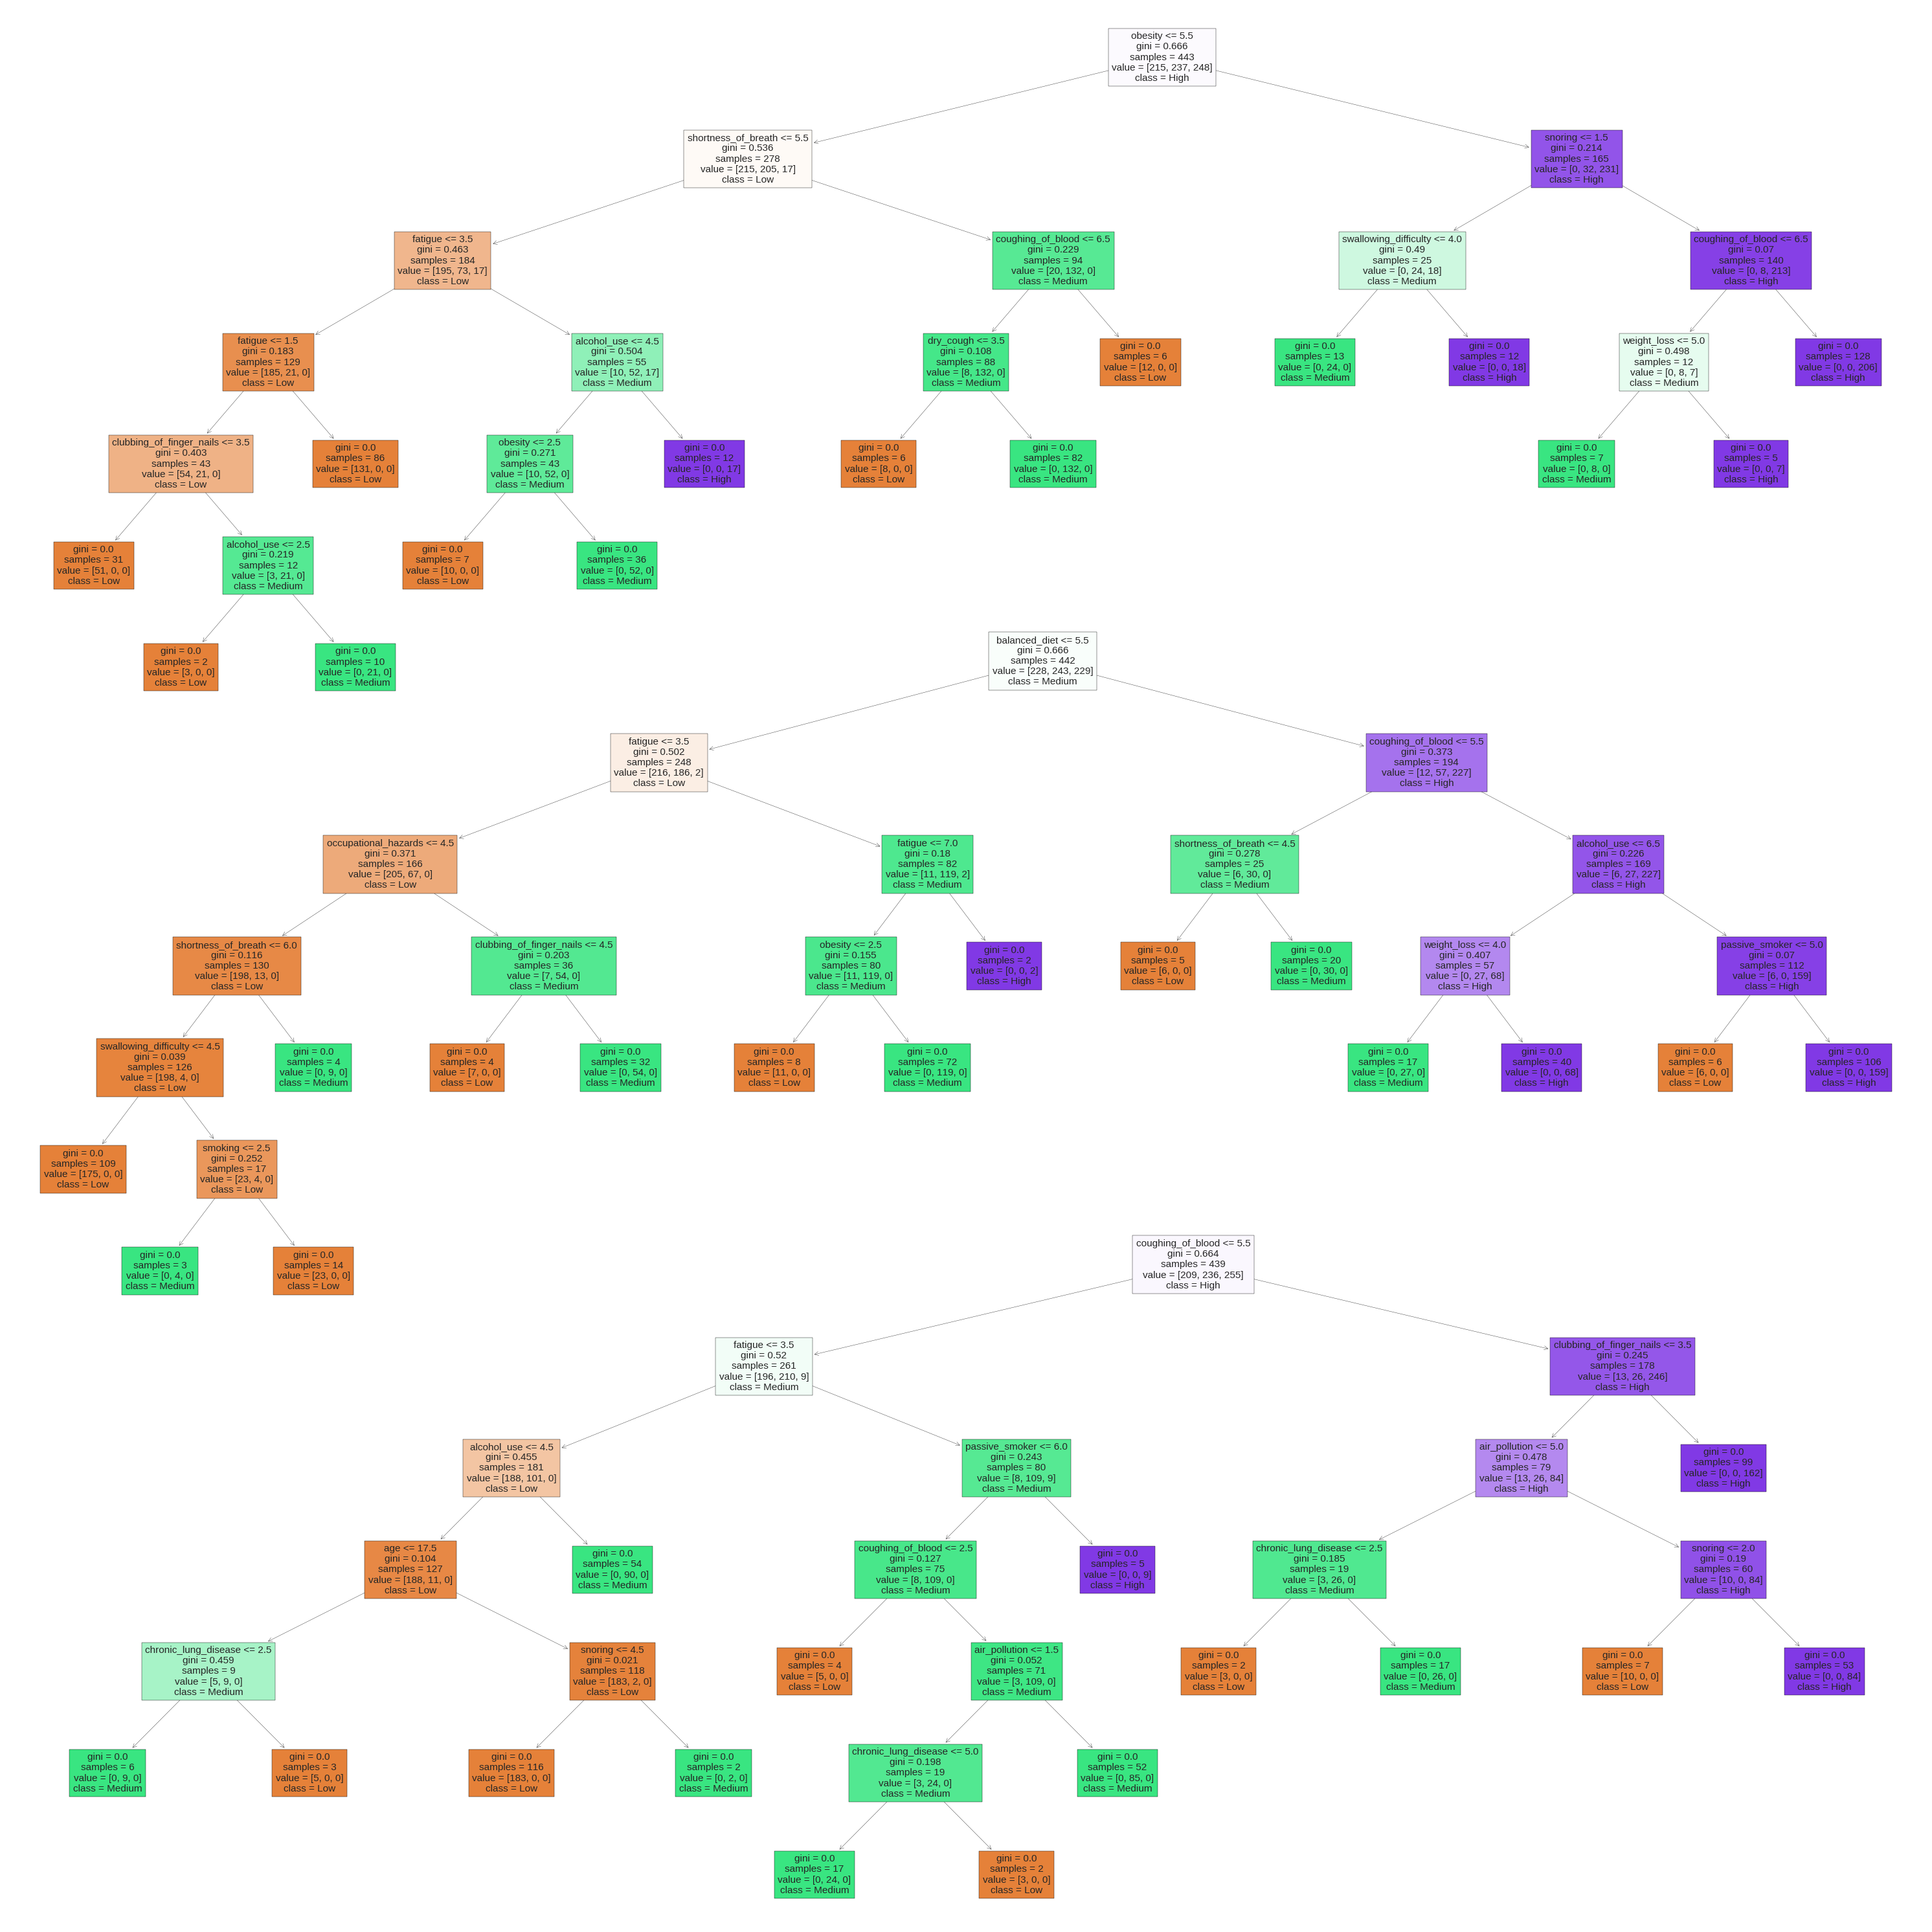

In [20]:
from sklearn import tree

trees = len(rfc_model.estimators_)
cl = ['Low', 'Medium', 'High']

fig, ax = plt.subplots(trees, 1, figsize=(30,10*trees))

for i, forest in enumerate(rfc_model.estimators_):
    if trees > 1:
        tree.plot_tree(forest,
                       feature_names=X.columns,
                       class_names=cl,
                       filled=True,
                       fontsize=11,
                       ax=ax[i])
    else:
        tree.plot_tree(forest,
                       feature_names=X.columns,
                       class_names=cl,
                       filled=True,
                       fontsize=11)
    
plt.tight_layout(h_pad=-10)
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       117

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



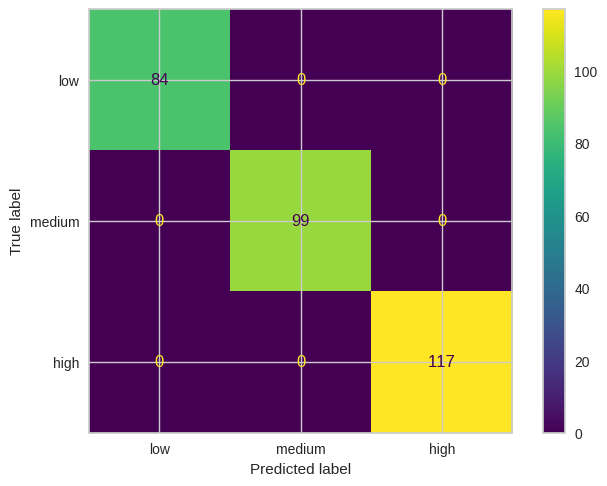

In [21]:
# Confusion Matrix for Random Forest Classifier 
cm = confusion_matrix(y_test, rfc_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['low', 'medium', 'high'])
disp.plot()

# Model report
ml_accuracies_rfc = accuracy_score(y_test, rfc_pred)
print(classification_report(y_test, rfc_pred))


In [22]:
# Feature importance for Random Forest Classifier
feature_importances_rfc_model = pd.DataFrame(X_train.columns)
feature_importances_rfc_model.columns = ['feature']
feature_importances_rfc_model["ml_accuracies_rfc"] = pd.Series(rfc_model.feature_importances_)
feature_importances_rfc_model.sort_values(by="ml_accuracies_rfc", ascending=False)

feature  ml_accuracies_rfc
13         coughing_of_blood           0.184579
9                    obesity           0.151791
14                   fatigue           0.141321
8              balanced_diet           0.109434
3                alcohol_use           0.105724
16       shortness_of_breath           0.067482
5       occupational_hazards           0.045878
19  clubbing_of_finger_nails           0.034573
15               weight_loss           0.032963
22                   snoring           0.030112
2              air_pollution           0.025812
11            passive_smoker           0.019478
18     swallowing_difficulty           0.015453
7       chronic_lung_disease           0.012284
21                 dry_cough           0.010794
0                        age           0.007452
10                   smoking           0.004870
12                chest_pain           0.000000
1                     gender           0.000000
6               genetic_risk           0.000000
17                  wheezing           0.000000
4               dust_allergy           0.000000
20             frequent_cold           0.000000

/home/rashmi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


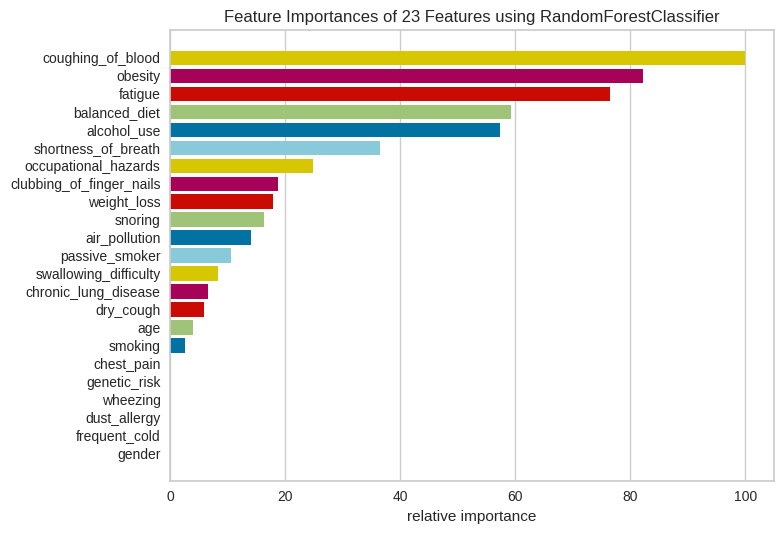

<Axes: title={'center': 'Feature Importances of 23 Features using RandomForestClassifier'}, xlabel='relative importance'>

In [23]:
viz=FeatureImportances(rfc_model)
viz.fit(X,y)
viz.show()

# AdaBoostClassifier

In [24]:
param_ADA = {
    'n_estimators': [50, 100, 200], 
    'learning_rate': [0.01, 0.1, 1],
    'random_state' : [42],
    'algorithm': ['SAMME.R'],   
}

In [25]:
%%time
model_tuning = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_ADA, cv=5)
model_tuning.fit(X_train, y_train)

best_params = model_tuning.best_params_
print("Best Parameters:", best_params)
ada_model = AdaBoostClassifier(**best_params)
ada_model.fit(X_train, y_train)

Best Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 0.01, 'n_estimators': 200, 'random_state': 42}
CPU times: user 9.4 s, sys: 6.64 ms, total: 9.4 s
Wall time: 9.42 s


AdaBoostClassifier(learning_rate=0.01, n_estimators=200, random_state=42)

In [26]:
# Predictions using AdaBoostClassifier 
ada_pred = ada_model.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        84
           1       0.93      1.00      0.96        99
           2       1.00      1.00      1.00       117

    accuracy                           0.97       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.98      0.97      0.97       300



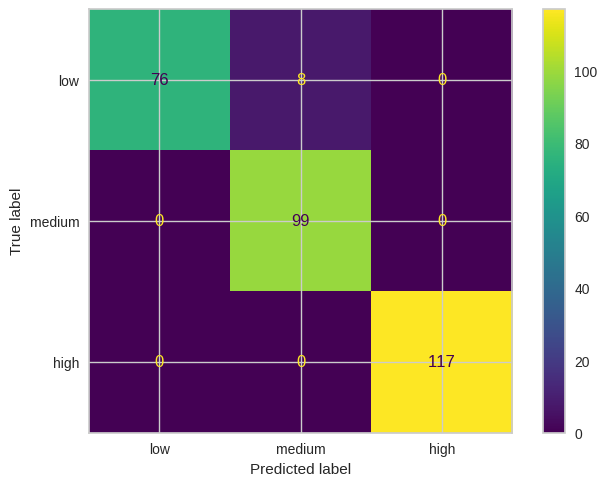

In [27]:
# Confusion Matrix for AdaBoostClassifier
cm = confusion_matrix(y_test, ada_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['low', 'medium', 'high'])
disp.plot()

# Model report
ml_accuracies_ada = accuracy_score(y_test, ada_pred)
print(classification_report(y_test, ada_pred))

In [28]:
# Feature importance for ADABoostClassifier
feature_importances_ada_model = pd.DataFrame(X_train.columns)
feature_importances_ada_model.columns = ['feature']
feature_importances_ada_model["ml_accuracies_ada"] = pd.Series(ada_model.feature_importances_)
feature_importances_ada_model.sort_values(by="ml_accuracies_ada", ascending=False)

feature  ml_accuracies_ada
14                   fatigue              0.345
3                alcohol_use              0.175
17                  wheezing              0.135
9                    obesity              0.125
19  clubbing_of_finger_nails              0.100
13         coughing_of_blood              0.060
11            passive_smoker              0.055
21                 dry_cough              0.005
20             frequent_cold              0.000
18     swallowing_difficulty              0.000
16       shortness_of_breath              0.000
15               weight_loss              0.000
0                        age              0.000
12                chest_pain              0.000
1                     gender              0.000
10                   smoking              0.000
8              balanced_diet              0.000
7       chronic_lung_disease              0.000
6               genetic_risk              0.000
5       occupational_hazards              0.000
4               dust_allergy              0.000
2              air_pollution              0.000
22                   snoring              0.000

/home/rashmi/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


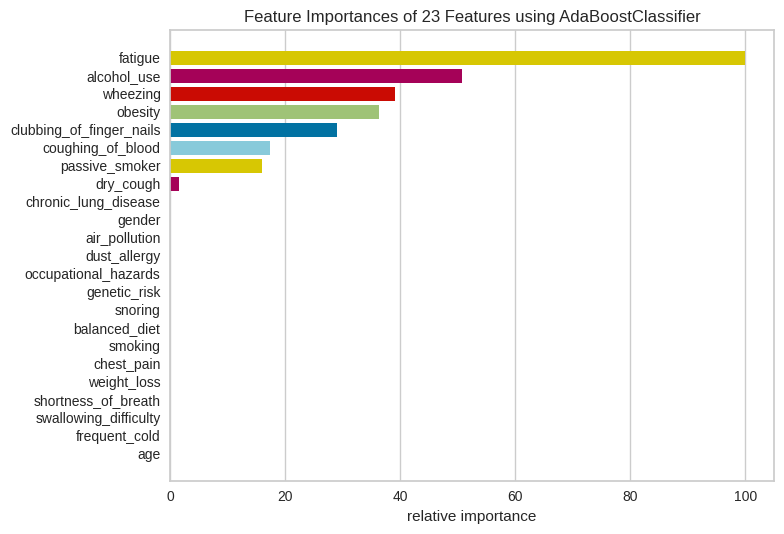

<Axes: title={'center': 'Feature Importances of 23 Features using AdaBoostClassifier'}, xlabel='relative importance'>

In [29]:
viz = FeatureImportances(ada_model)
viz.fit(X, y)
viz.show()

# XGBoost Classifier

In [30]:
params_XGB ={'n_estimators': [100, 200, 300],
             'num_leaves': [2, 5, 7, 10],
             'max_depth': [2, 3, 5],         
             'subsample': [0.01],
             'learning_rate': [0.01],
             'objective': ['multi:softmax'],
             'random_state' : [42],
             'num_class': [3]}

In [31]:
%%time
model_tuning = GridSearchCV(estimator=XGBClassifier(), param_grid=params_XGB, cv=5)
model_tuning.fit(X_train, y_train)

best_params = model_tuning.best_params_
print("Best Parameters:", best_params)
xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

/home/rashmi/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:46:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rashmi/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:46:01] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rashmi/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:46:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rashmi/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:46:02] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "num_leaves" } are not used.

  warnings.warn(smsg, UserWarning)
/home/rashmi/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [23:46:02] WARNING: /workspace/src/learner.cc:

Best Parameters: {'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'num_class': 3, 'num_leaves': 2, 'objective': 'multi:softmax', 'random_state': 42, 'subsample': 0.01}
CPU times: user 3min 14s, sys: 4.1 s, total: 3min 18s
Wall time: 28.1 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=3,
              num_leaves=2, ...)

In [32]:
# Predictions using XGBoostClassifier 
xgb_pred = xgb_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.84      0.98      0.90        84
           1       1.00      0.71      0.83        99
           2       0.89      1.00      0.94       117

    accuracy                           0.90       300
   macro avg       0.91      0.89      0.89       300
weighted avg       0.91      0.90      0.89       300



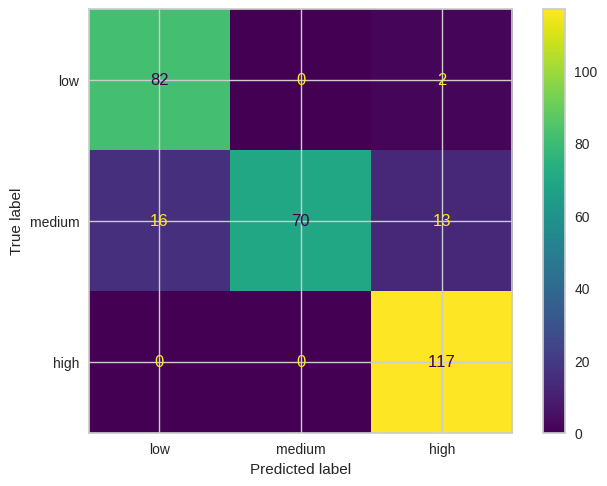

In [33]:
# Confusion Matrix for XGBoostClassifier
cm = confusion_matrix(y_test, xgb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['low', 'medium', 'high'])
disp.plot()

# Model report
#ml_accuracies['XGBoostClassifier' = accuracy_score(y_test, xgb_pred)
ml_accuracies_xgb = accuracy_score(y_test, xgb_pred)

print(classification_report(y_test, xgb_pred))

In [34]:
# Feature importance for XGBoostClassifier
feature_importances_xgb_model = pd.DataFrame(X_train.columns)
feature_importances_xgb_model.columns = ['feature']
feature_importances_xgb_model["ml_accuracies_xgb"] = pd.Series(xgb_model.feature_importances_)
feature_importances_xgb_model.sort_values(by="ml_accuracies_xgb", ascending=False)



feature  ml_accuracies_xgb
4               dust_allergy           0.061412
22                   snoring           0.056812
9                    obesity           0.054846
16       shortness_of_breath           0.054540
17                  wheezing           0.052597
8              balanced_diet           0.051882
3                alcohol_use           0.051610
2              air_pollution           0.050508
13         coughing_of_blood           0.050172
7       chronic_lung_disease           0.049200
10                   smoking           0.047728
14                   fatigue           0.041283
20             frequent_cold           0.040772
12                chest_pain           0.039063
11            passive_smoker           0.038512
19  clubbing_of_finger_nails           0.037852
21                 dry_cough           0.037520
6               genetic_risk           0.036109
15               weight_loss           0.031386
1                     gender           0.030862
18     swallowing_difficulty           0.028700
5       occupational_hazards           0.028668
0                        age           0.027968

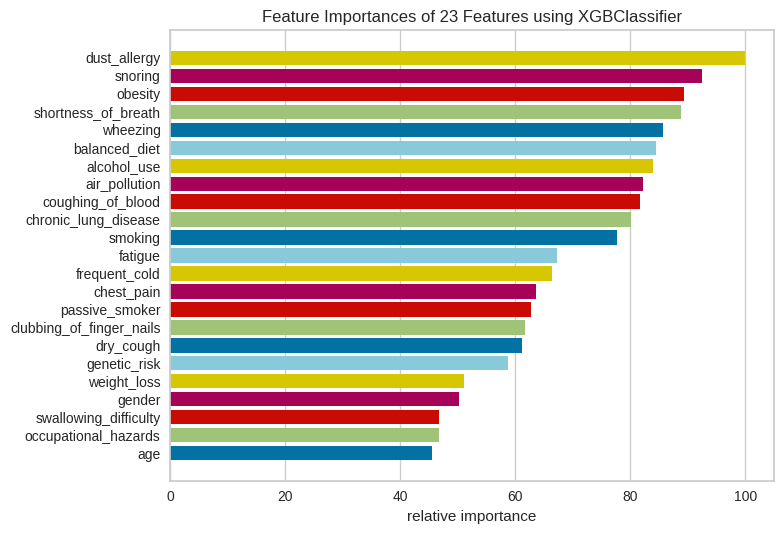

<Axes: title={'center': 'Feature Importances of 23 Features using XGBClassifier'}, xlabel='relative importance'>

In [35]:
viz = FeatureImportances(xgb_model)
viz.fit(X, y)
viz.show()

# Logistic Regression Model

In [36]:
# Logistic Regression model with "multinomial" multiclass.
lrm_model = LogisticRegression(multi_class='multinomial', solver='newton-cg', random_state=40)

# fitting model
lrm_model.fit(X_train, y_train)

# predicting with model
lrm_pred = lrm_model.predict(X_test)

# Printing model coefficents
print('Intercept: \n', lrm_model.intercept_)
print('Coefficients: \n', lrm_model.coef_)

Intercept: 
 [ 36.7164495   -0.45274704 -36.26370246]
Coefficients: 
 [[-0.03679725  0.07868986 -0.14372125 -0.41359781 -0.28470932  0.03228993
  -0.46932636 -0.21877138 -0.03312036 -1.01589117 -0.02798936 -0.91213825
   0.28619955 -0.83420089 -0.74981479  0.03596878 -0.23744426 -0.90157445
  -0.8013491  -0.77615564 -0.64109321 -0.52193858 -0.69790084]
 [ 0.04252993 -0.14196643 -0.32681983 -0.19289529  0.41656126 -0.02792512
   0.22965746 -0.13945015 -0.30280664  0.52073835 -0.08854837  0.10990828
  -0.35243023 -0.00560069 -0.09403983 -0.41793015 -0.24250709  0.72504121
  -0.04127342  0.33984795  0.21089015  0.13028766  0.41266612]
 [-0.00573268  0.06327657  0.47054108  0.6064931  -0.13185194 -0.00436481
   0.2396689   0.35822153  0.33592701  0.49515281  0.11653774  0.80222996
   0.06623068  0.83980159  0.84385462  0.38196137  0.47995134  0.17653324
   0.84262251  0.43630769  0.43020306  0.39165092  0.28523472]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       117

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



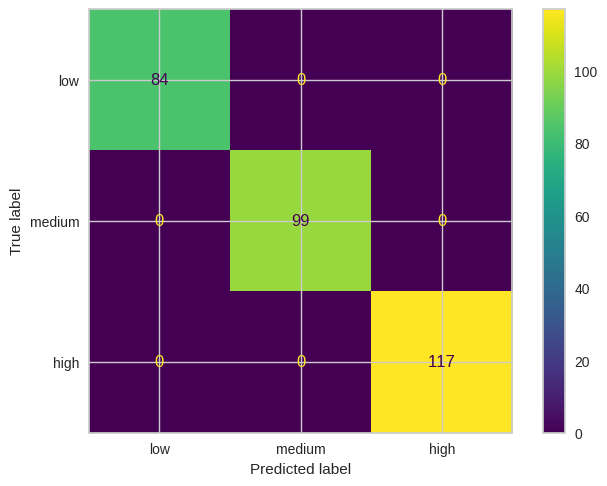

In [37]:
# confusion matrix for logistic regression
cm = confusion_matrix(y_test, lrm_pred)#, labels=MR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['low', 'medium', 'high'])
disp.plot()

# Model report
ml_accuracies_lrm = accuracy_score(y_test, lrm_pred)
print(classification_report(y_test, lrm_pred))

# KNN Model

In [38]:
# Train K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn_model.fit(X_train, y_train)

knn_pred = knn_model.predict(X_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       117

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



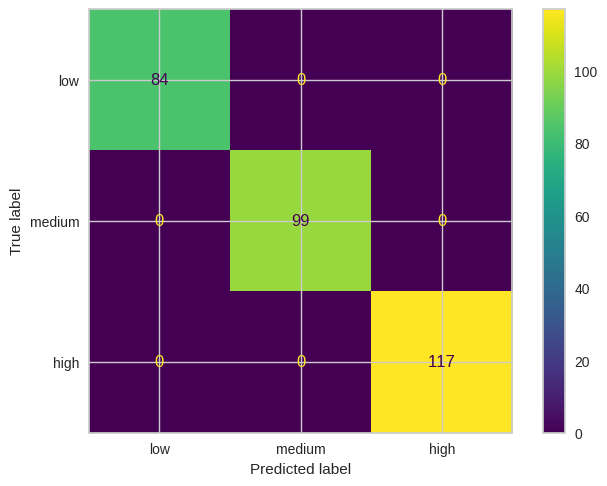

In [39]:
# Confusion Matrix for KNN Model 
cm = confusion_matrix(y_test, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['low', 'medium', 'high'])
disp.plot()

# Model report
ml_accuracies_knn = accuracy_score(y_test, knn_pred)
print(classification_report(y_test, knn_pred))

# Support Vector Machines

In [40]:
# Train Support Vector Machines
svm_model = SVC(C=0.6, kernel='linear')
svm_model.fit(X_train, y_train)

# Predictions using Support Vector Machines
svm_pred = svm_model.predict(X_test)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        84
           1       1.00      1.00      1.00        99
           2       1.00      1.00      1.00       117

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



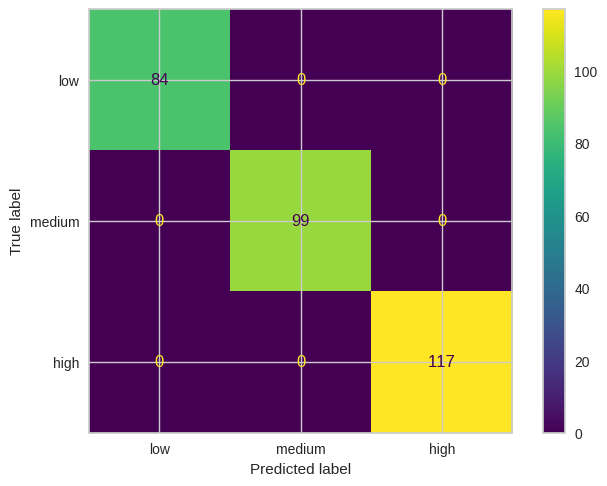

In [41]:
# Confusion Matrix for SVM 
cm = confusion_matrix(y_test, svm_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['low', 'medium', 'high'])
disp.plot()

# Model report
ml_accuracies_svm = accuracy_score(y_test, svm_pred)
print(classification_report(y_test, svm_pred))